<a href="https://colab.research.google.com/github/taikis/research_colab_frcnn/blob/develop/Faster_R_CNN_kuzushizi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Faster R-CNNColab実装！
コードにちょくちょく至らぬところはあると思いますがご容赦願います

## 前準備(ドライブのマウント)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## ハイパーパラメータ、pathの指定

In [ ]:
import numpy as np
import pandas as pd
 
from PIL import Image
from glob import glob
import xml.etree.ElementTree as ET 
import cv2
 
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import TensorDataset
import os
#pathの指定(colab_frcnn直下まで)
path='/content/drive/My Drive/research/colab_frcnn-main/'
bdd_xml=path+"/kuzushiji/xml"
bdd_img=path+"/kuzushiji/train_images"
test_path=path+"/kuzushiji/d_test_images"

#datasetのクラス指定
dataset_class_csv = pd.read_csv(path+ '/kuzushiji/unicode_translation.csv')
dataset_class = dataset_class_csv.T.values.tolist()[0]
#print(dataset_class)
#表示したいラベルの色の指定
#注意！！一番最初は背景クラスを示すので(0,0,0)にする
colors = ((0,0,0),(255,0,0),(0,255,0),(0,0,255),(100,100,100),(50,50,50),(255,255,0),(255,0,255),(0,255,255),(100,100,0),(0,100,100))

#ハイパーパラメータの指定
epochs=5
batch_size=1
scale=720#画像のスケール設定(縦の大きさを入力)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 


['U+0031', 'U+0032', 'U+0034', 'U+0036', 'U+0039', 'U+003F', 'U+2000B', 'U+20D45', 'U+2123D', 'U+22999', 'U+22CE3', 'U+231C3', 'U+2324A', 'U+233D0', 'U+23D0E', 'U+241C6', 'U+242CE', 'U+2437D', 'U+24E30', 'U+24E60', 'U+24FA3', 'U+2564A', 'U+25750', 'U+25877', 'U+25A0', 'U+25A1', 'U+25B2', 'U+25B3', 'U+25CB', 'U+25CF', 'U+25DA1', 'U+25E2E', 'U+25EF', 'U+25FFB', 'U+264B3', 'U+266B0', 'U+27752', 'U+28263', 'U+29780', 'U+29DDA', 'U+29E75', 'U+3002', 'U+3005', 'U+3006', 'U+3007', 'U+300C', 'U+300D', 'U+3031', 'U+3032', 'U+303B', 'U+303D', 'U+3042', 'U+3044', 'U+3046', 'U+3048', 'U+304A', 'U+304B', 'U+304C', 'U+304D', 'U+304E', 'U+304F', 'U+3050', 'U+3051', 'U+3052', 'U+3053', 'U+3054', 'U+3055', 'U+3056', 'U+3057', 'U+3058', 'U+3059', 'U+305A', 'U+305B', 'U+305C', 'U+305D', 'U+305E', 'U+305F', 'U+3060', 'U+3061', 'U+3062', 'U+3063', 'U+3064', 'U+3065', 'U+3066', 'U+3067', 'U+3068', 'U+3069', 'U+306A', 'U+306B', 'U+306C', 'U+306D', 'U+306E', 'U+306F', 'U+3070', 'U+3071', 'U+3072', 'U+3073', '

## その1データの読み込み（dataloaderの作成）

In [ ]:
class xml2list(object):
    
    def __init__(self, classes):
        self.classes = classes
        
    def __call__(self, xml_path):
        
        ret = []
        xml = ET.parse(xml_path).getroot()
        
        boxes = []
        labels = []
        zz=0
        
        for zz,obj in enumerate(xml.iter('object')):
            
            label = obj.find('name').text
            ##指定クラスのみ

            if label in self.classes :
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(self.classes.index(label))
            else:
                continue
        num_objs = zz +1

        anno = {'bboxes':boxes, 'labels':labels}

        return anno,num_objs

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    
        def __init__(self,image_dir,xml_paths,scale,classes):
            
            super().__init__()
            self.image_dir = image_dir
            self.xml_paths = xml_paths
            self.image_ids = sorted(glob('{}/*'.format(xml_paths)))
            self.scale=scale
            self.classes=classes
            
        def __getitem__(self, index):
    
            transform = transforms.Compose([
                                            transforms.ToTensor()
            ])
    
            # 入力画像の読み込み
            image_id=self.image_ids[index].split("/")[-1].split(".")[0]
            image = Image.open(f"{self.image_dir}/{image_id}.jpg")
            
            
            #画像のスケール変換
            t_scale_tate=self.scale ##目標のスケール(縦)
            #縮小比を計算
            ratio=t_scale_tate/image.size[1]
            ##目標横スケールを計算
            t_scale_yoko=image.size[0]*ratio
            t_scale_yoko=int(t_scale_yoko)
            
            #print('縮小前:',image.size)
            #print('縮小率:',ratio)
            #リサイズ
            image = image.resize((t_scale_yoko,t_scale_tate))
            #print('縮小後:',image.size)
  
            image = transform(image)
        
            transform_anno = xml2list(self.classes)
            path_xml=f'{self.xml_paths}/{image_id}.xml'
            

            annotations,obje_num= transform_anno(path_xml)

            boxes = torch.as_tensor(annotations['bboxes'], dtype=torch.int64)
            labels = torch.as_tensor(annotations['labels'], dtype=torch.int64)

          
            #bboxの縮小
            #print('縮小前:',boxes)
            boxes=boxes*ratio
            #print('縮小後:',boxes)
        
            area = (boxes[:, 3]-boxes[:, 1]) * (boxes[:, 2]-boxes[:, 0])
            area = torch.as_tensor(area, dtype=torch.float32)

            iscrowd = torch.zeros((obje_num,), dtype=torch.int64)

            target = {}
            target["boxes"] = boxes
            target["labels"] = labels+1
            target["image_id"] = torch.tensor([index])
            target["area"] = area
            target["iscrowd"] = iscrowd
            return image, target,image_id
        
        def __len__(self):

            return len(self.image_ids)

In [ ]:
def dataloader (data,dataset_class,batch_size,scale=720):
    xml_paths=data[0]
    image_dir1=data[1]
    dataset = MyDataset(image_dir1,xml_paths,scale,dataset_class)

    #データのロード
    torch.manual_seed(2020)
    def collate_fn(batch):
        return tuple(zip(*batch))

    train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True,collate_fn=collate_fn)
    

    return train_dataloader

# modelの定義

In [ ]:
def model ():
    #モデルの定義
    
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    num_classes=len(dataset_class)+1
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model



# train

In [ ]:
data_ALL=[bdd_xml,bdd_img]
train_dataloader=dataloader(data_ALL,dataset_class,batch_size,scale)

model=model()
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = epochs




model.cuda()

model.train()#学習モードに移行

loss_list=[]
for epoch in range(num_epochs):
    loss_epo=[]
 
    #model.train()#これから学習しますよ
    
    for i, batch in enumerate(train_dataloader):
        
 
        images, targets, image_ids = batch#####　batchはそのミニバッジのimage、tagets,image_idsが入ってる
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        
        ##学習モードでは画像とターゲット（ground-truth）を入力する
        ##返り値はdict[tensor]でlossが入ってる。（RPNとRCNN両方のloss）
        loss_dict= model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        #lossの保存
        loss_epo.append(loss_value)
 
        if (i+1) % 10== 0:
          print(f"epoch #{epoch+1} Iteration #{i+1} loss: {loss_value}") 
          
        
    #Epochごとのlossの保存
    loss_list.append(np.mean(loss_epo))
    torch.save(model, path+'model' + str(epoch) + '.pt')

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch #1 Iteration #10 loss: 3.6028645038604736
epoch #1 Iteration #20 loss: 3.361009359359741
epoch #1 Iteration #30 loss: 3.5283753871917725
epoch #1 Iteration #40 loss: 3.450706958770752
epoch #1 Iteration #50 loss: 3.295834541320801
epoch #1 Iteration #60 loss: 2.973114252090454
epoch #1 Iteration #70 loss: 3.0525505542755127
epoch #1 Iteration #80 loss: 3.155188798904419
epoch #1 Iteration #90 loss: 3.1966793537139893
epoch #1 Iteration #100 loss: 2.764145612716675
epoch #1 Iteration #110 loss: 2.7114508152008057
epoch #1 Iteration #120 loss: 3.6433334350585938
epoch #1 Iteration #130 loss: 2.5915775299072266
epoch #1 Iteration #140 loss: 2.535038709640503
epoch #1 Iteration #150 loss: 2.5868895053863525
epoch #1 Iteration #160 loss: 2.5081067085266113
epoch #1 Iteration #170 loss: 2.599653720855713
epoch #1 Iteration #180 loss: 2.7396748065948486
epoch #1 Iteration #190 loss: 2.3533384799957275
epoch #1 Iteration #200 loss: 2.140223741531372
epoch #1 Iteration #210 loss: 2.416943

# Test
学習結果をもとに結果をテスト

In [ ]:
import glob
import matplotlib.pyplot as plt
data_class=dataset_class
data_class.insert(0, "__background__")
classes = tuple(data_class)

#学習済みモデルで推論する場合
model=torch.load(path+'/model2.pt')

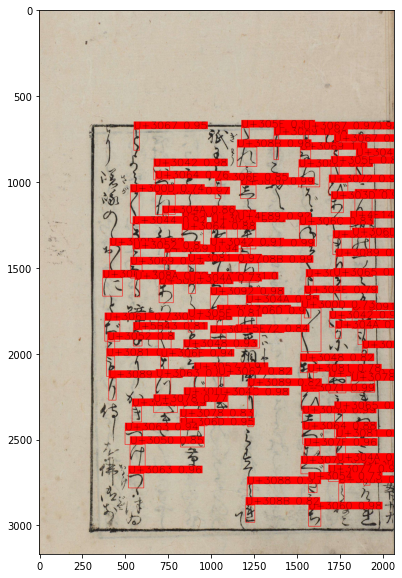

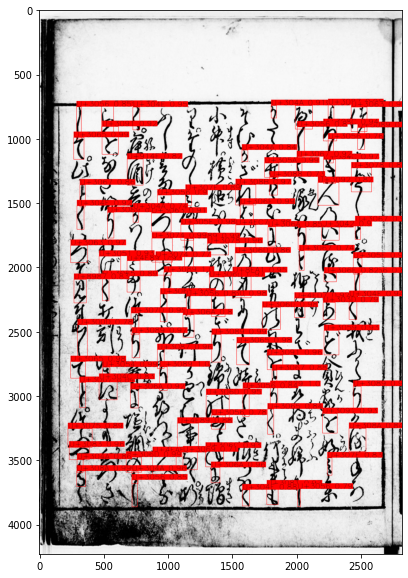

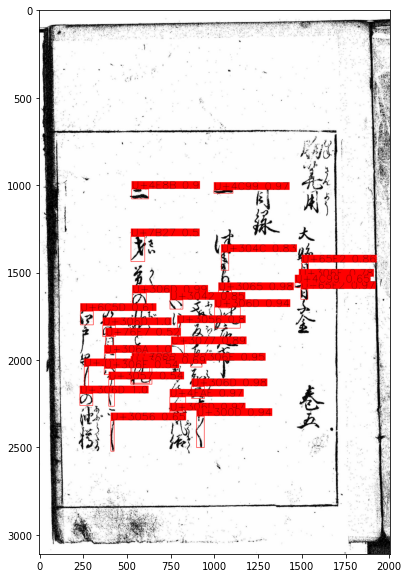

In [ ]:
model.to(device)

model.eval()
for imgfile in sorted(glob.glob(test_path+'/*')):
    
    img = cv2.imread(imgfile)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image_tensor = torchvision.transforms.functional.to_tensor(img)

    with torch.no_grad():
        prediction = model([image_tensor.to(device)])
    
    for i,box in enumerate(prediction[0]['boxes']):
        score = prediction[0]['scores'][i].cpu().numpy()
        if score > 0.5:
            score = round(float(score),2)
            cat = prediction[0]['labels'][i].cpu().numpy()
            txt = '{} {}'.format(classes[int(cat)], str(score))
            font = cv2.FONT_HERSHEY_SIMPLEX
            cat_size = cv2.getTextSize(txt, font, 2, 2)[0]
            c = (255,0,0)
            box=box.cpu().numpy().astype('int')
            cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), c , 2)
            cv2.rectangle(img,(box[0], box[1] - cat_size[1] - 2),(box[0] + cat_size[0], box[1] - 2), c, -1)
            cv2.putText(img, txt, (box[0], box[1] - 2), font, 2, (0, 0, 0), thickness=1, lineType=cv2.LINE_AA)


    plt.figure(figsize=(15,10))
    plt.imshow(img)
plt.show()